True
False
True
True
True
True
False
True
True
False
True
True
True
True
True
False
False
True
True
False
True
True
True
False
True
True
True
True
True
False
False
True
True
False
True
True
False
False
True
True
False
False
False
True
False
False
True
False
True
False
True
False
False
True
True
True
False
False
False
True
True
True
False
True
True
True
True
False
False
False
True
False
False
False
True
False
False
False
True
True
True
True
True
False
False
True
True
True
False
True
True
False
True
False
False
True
True
False
False
False
True
True
False
False
False
True
False
True
False
False
False
True
True
True
True
False
True
False
False
True
True
False
True
True
True
False
False
False
True
True
False
False
True
False
True
False
True
True
True
False
False
False
True
True
False
True
False
True
True
True
True
True
True
True
True
False
False
True
False
True
True
False
True
False
True
True
True
False
True
False
True
False
True
False
True
False
False
False
True
True
False
True
False
False

<function matplotlib.pyplot.show(*args, **kw)>

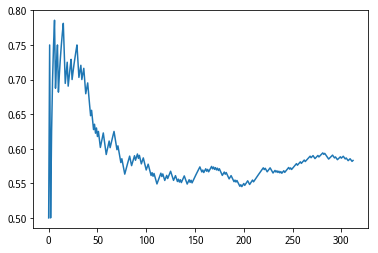

In [3]:
import talib
import pandas as pd
from jqdata import *
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import datetime
import matplotlib.pyplot as plt

import warnings 
# 取消警告，2018-12-10添加
warnings.filterwarnings("ignore")

test_stock = '399300.XSHE'
# 实验数据开始的日期，注意日期需要是一个交易日
start_date = datetime.date(2010, 1, 4)
# 实验数据终止的日期，也需要是个交易日
end_date = datetime.date(2016, 6, 3)
# 开始预测的日期，也需要是个交易日
test_start_date = datetime.date(2015, 2, 26)

# 得到所有的交易日列表
trading_days = get_all_trade_days().tolist() # 2018-12-10修改，添加.tolist()
start_date_index = trading_days.index(start_date)
end_date_index = trading_days.index(end_date)
test_start_index = trading_days.index(test_start_date)
# 保存每一天预测的结果，如果某天预测对了，保存1，如果某天预测错了，保存-1
result_list = []

# 每一天都对应于一个index_end
for index_end in range(test_start_index, end_date_index):
    # x_all中保存所有的特征信息
    # y_all中保存所有的标签信息（要预测的对象）
    x_all = []
    y_all = []
    # 这个时间段产生所有的训练数据
    for index in range(start_date_index, index_end):
        #计算特征的代码
        start_day = trading_days[index - 35]
        end_day = trading_days[index]
        stock_data = get_price(test_stock, start_date=start_day, end_date=end_day, \
                               frequency='daily', fields=['close','high','low','volume'])
        close_prices = stock_data['close'].values
        high_prices = stock_data['high'].values
        low_prices = stock_data['low'].values
        volumes = stock_data['volume'].values
        #通过数据计算指标
        sma_data = talib.SMA(close_prices)[-1]    
        wma_data = talib.WMA(close_prices)[-1]
        mom_data = talib.MOM(close_prices)[-1]
        stck, stcd = talib.STOCH(high_prices, low_prices, close_prices)
        stck_data = stck[-1]
        stcd_data = stcd[-1]

        macd, macdsignal, macdhist = talib.MACD(close_prices)
        macd_data = macd[-1]
        rsi_data = talib.RSI(close_prices,timeperiod=10)[-1]
        willr_data = talib.WILLR(high_prices, low_prices, close_prices)[-1]
        cci_data = talib.CCI(high_prices, low_prices, close_prices)[-1]
        
        mfi_data = talib.MFI(high_prices, low_prices, close_prices, volumes)[-1]
        obv_data = talib.OBV(close_prices, volumes)[-1]
        roc_data = talib.ROC(close_prices)[-1]
        cmo_data = talib.CMO(close_prices)[-1]
        
        # 保存训练数据中的一组训练数据
        features = []
        features.append(sma_data)
        features.append(wma_data)
        features.append(mom_data)
        features.append(stck_data)
        features.append(stcd_data)
        features.append(macd_data)
        features.append(rsi_data)
        features.append(willr_data)
        features.append(cci_data)
        features.append(mfi_data)
        features.append(obv_data)
        features.append(roc_data)
        features.append(cmo_data)
        # 特征离散化的时候用到的临时变量，离散化之后删除
        features.append(close_prices[-1])
    
        # 计算分类标签的代码
        start_day = trading_days[index]
        end_day = trading_days[index + 1]
        stock_data = get_price(test_stock, start_date=start_day, end_date=end_day, \
                               frequency='daily', fields=['close','high','low','volume'])
        close_prices = stock_data['close'].values
        
        label = False
        if close_prices[-1] > close_prices[-2]:
            label = True
        
        x_all.append(features)
        y_all.append(label)
        
    #连续数值离散化
    #从后面开始向前面遍历，第一行数据需要舍弃,range只包含第一个元素，不包含第二个元素
    for index in range(len(x_all)-1, 0, -1):
        # SMA
        if x_all[index][0] < x_all[index][-1]:
            x_all[index][0] = 1
        else:
            x_all[index][0] = -1
        # WMA
        if x_all[index][1] < x_all[index][-1]:
            x_all[index][1] = 1
        else:
            x_all[index][1] = -1
        # MOM
        if x_all[index][2] > 0:
            x_all[index][2] = 1
        else:
            x_all[index][2] = -1
        # STCK
        if x_all[index][3] > x_all[index-1][3]:
            x_all[index][3] = 1
        else:
            x_all[index][3] = -1
        # STCD
        if x_all[index][4] > x_all[index-1][4]:
            x_all[index][4] = 1
        else:
            x_all[index][4] = -1
        # MACD
        if x_all[index][5] > x_all[index-1][5]:
            x_all[index][5] = 1
        else:
            x_all[index][5] = -1

        # RSI
        if x_all[index][6] > 70:
            x_all[index][6] = -1
        elif x_all[index][6] < 30:
            x_all[index][6] = 1
        else:
            if x_all[index][6] > x_all[index-1][6]:
                x_all[index][6] = 1
            else:
                x_all[index][6] = -1
        # WILLR
        if x_all[index][7] > x_all[index-1][7]:
            x_all[index][7] = 1
        else:
            x_all[index][7] = -1
        # CCI
        if x_all[index][8] > 200:
            x_all[index][8] = -1
        elif x_all[index][8] < -200:
            x_all[index][8] = 1
        else:
            if x_all[index][8] > x_all[index-1][8]:
                x_all[index][8] = 1
            else:
                x_all[index][8] = -1
                
        # MFI
        if x_all[index][9] > 90:
            x_all[index][9] = -1
        elif x_all[index][9] < 10:
            x_all[index][9] = 1
        else:
            if x_all[index][9] > x_all[index-1][9]:
                x_all[index][9] = 1
            else:
                x_all[index][9] = -1
        # OBV
        if x_all[index][10] > x_all[index-1][10]:
            x_all[index][10] = 1
        else:
            x_all[index][10] = -1
        # ROC
        if x_all[index][11] > 0:
            x_all[index][11] = 1
        else:
            x_all[index][11] = -1
        # CMO
        if x_all[index][12] > 50:
            x_all[index][12] = -1
        elif x_all[index][12] < -50:
            x_all[index][12] = 1
        else:
            if x_all[index][12] > x_all[index-1][12]:
                x_all[index][12] = 1
            else:
                x_all[index][12] = -1        
        # 删除价格
        x_all[index].pop(-1)
                
        
    # 去除第一行数据
    x_all = x_all[1:]
    y_all = y_all[1:]
    # 训练数据是除去最后一个数据之后的全部数据
    x_train = x_all[:-1]
    y_train = y_all[:-1]
    # 测试数据就是最后一个数据
    x_test = x_all[-1]
    y_test = y_all[-1]
    
    # 以下三行代码分别是利用SVM，随机森林，朴素贝叶斯，调用其中的一句就好
    clf = svm.SVC()
#     clf = RandomForestClassifier(n_estimators=50)
#     clf = GaussianNB()
    # 训练过程
    clf.fit(x_train, y_train)
    # 预测过程
    prediction = clf.predict(x_test)
    if prediction == y_test:
        print('True')
        result_list.append(1)
    else:
        print('False')
        result_list.append(-1)
#将准确率曲线画出来
x = range(0, len(result_list))
y = []
for i in range(0, len(result_list)):
    y.append((1 + float(sum(result_list[:i])) / (i+1)) / 2)
line, = plt.plot(x, y)
plt.show